# `Сокеты, клиент-сервер`

In [7]:
# создание сокета, сервер
import socket

# https://docs.python.org/3/library/socket.html
sock=socket.socket(socket.AF_INET, socket.SOCK_STREAM)
sock.bind(("127.0.0.2", 10001)) # max port 65535
sock.listen(socket.SOMAXCONN)

conn, addr = sock.accept()
while True:
    data = conn.recv(1024)
    if not data:
        break
    # process data
    print(data.decode("utf8"))

conn.close()
sock.close()

GET / HTTP/1.1
Host: 127.0.0.2:10001
Connection: keep-alive
Cache-Control: max-age=0
Upgrade-Insecure-Requests: 1
User-Agent: Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/85.0.4183.83 Safari/537.36
Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3;q=0.9
Sec-Fetch-Site: none
Sec-Fetch-Mode: navigate
Sec-Fetch-User: ?1
Sec-Fetch-Dest: document
Accept-Encoding: gzip, deflate, br
Accept-Language: en-US,en;q=0.9,ru-RU;q=0.8,ru;q=0.7,uk;q=0.6




In [8]:
# создание сокета, клиент
import socket
sock = socket.socket()
sock.connect(("127.0.0.2", 10001))
sock.sendall("ping".encode("utf8"))
sock.close()

ConnectionRefusedError: [Errno 111] Connection refused

In [ ]:
# создание сокета, клиент
# более короткая запись
sock = socket.create_connection(("127.0.0.1", 10001))
sock.sendall("ping".encode("utf8"))
sock.close()

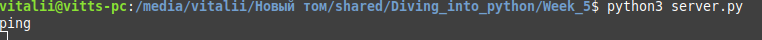
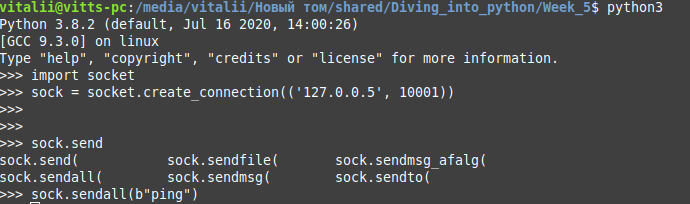

In [ ]:
# создание сокета, контекстный менеджер
# сервер
import socket

with socket.socket() as sock:
    sock.bind(("", 10001))
    sock.listen()
   
    while True:
        conn, addr = sock.accept()
        with conn:
            while True:
                data = conn.recv(1024)
                if not data:
                    break
                print(data.decode("utf8"))
# клиент
import socket
with socket.create_connection(("127.0.0.1", 10001)) as sock:
    sock.sendall("ping".encode("utf8"))

## `Таймауты и обработка сетевых ошибок`

In [ ]:
# создание сокета, контекстный менеджер
# сервер
import socket

with socket.socket() as sock:
    sock.bind(("", 10001))
    sock.listen()
   
    while True:
        conn, addr = sock.accept()
        conn.settimeout(5) # timeout := None|0|gt 0
        with conn:
            while True:
                try:
                    data = conn.recv(1024)
                except socket.timeout:
                    print("close connection by timeout")
                    break
                    
                if not data:
                    break
                print(data.decode("utf8"))

In [ ]:
# создание сокета, таймауты и обработка ошибок
# клиент
import socket

with socket.create_connection(("127.0.0.1", 10001), 5) as sock:
    # set socket read timeout
    sock.settimeout(2)
    try:
        sock.sendall("ping".encode("utf8"))
    except socket.timeout:
        print("send data timeout")
    except socket.error as ex:
        print("send data error:", ex)

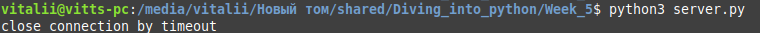
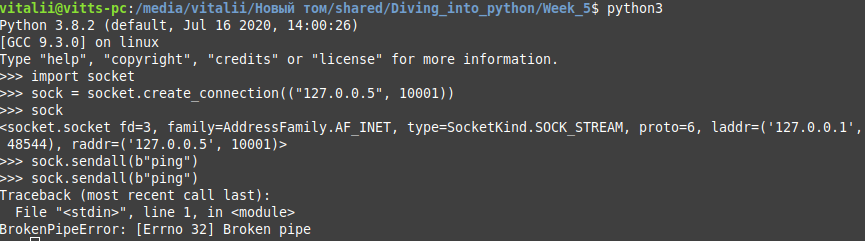

## `Обработка нескольких соединений`

In [ ]:
# обработка нескольких соединений одновременно, потоки
import socket
import threading

def process_request(conn, addr):
    print("connected client:", addr)
    with conn:
        while True:
            data = conn.recv(1024)
            if not data:
                break
            print(data.decode("utf8"))

with socket.socket() as sock:
    sock.bind(("", 10001))
    sock.listen()
    while True:
        conn, addr = sock.accept()
        th = threading.Thread(target=process_request,args=(conn, addr))
        th.start()

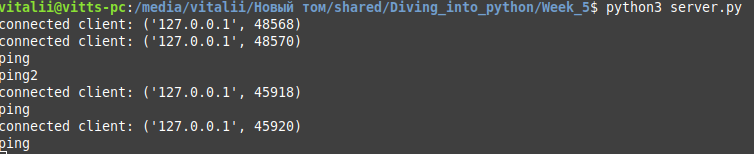
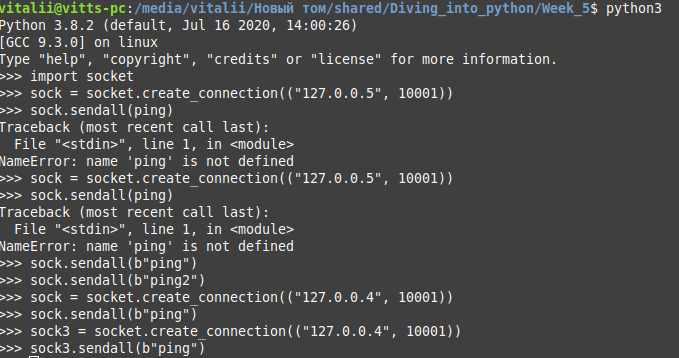

In [ ]:
# обработка нескольких соединений одновременно, процессы и потоки
import socket
with socket.socket() as sock:
    sock.bind(("", 10001))
    sock.listen()
    # создание нескольких процессов
    while True:
        # accept распределится "равномерно" между процессами
        conn, addr = sock.accept()
        # поток для обработки соединения
        with conn:
            while True:
                data = conn.recv(1024)
                if not data:
                    break
                print(data.decode("utf8"))

In [ ]:
# обработка нескольких соединений одновременно, процессы и потоки
import socket
import threading
import multiprocessing

with socket.socket() as sock:
    sock.bind(("", 10002))
    sock.listen()
    
    workers_count = 3
    workers_list = [multiprocessing.Process(target=worker,args=(sock,))for _ in range(workers_count)]
    for w in workers_list:
        w.start()
    for w in workers_list:
        w.join()
        
# обработка нескольких соединений одновременно, процессы и потоки
def worker(sock):
    while True:
        conn, addr = sock.accept()
        print("pid", os.getpid())
        th = threading.Thread(target=process_request,args=(conn, addr))
        th.start()

def process_request(conn, addr):
    print("connected client:", addr)
    with conn:
        while True:
            data = conn.recv(1024)
            if not data:
                break
        print(data.decode("utf8"))